In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set visualization style
sns.set(style="whitegrid")

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


In [20]:
data = pd.read_csv("exchange_rate.csv", parse_dates=['date'], index_col='date')


In [22]:
data.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-02-01,0.7818
1990-03-01,0.7867
1990-04-01,0.7860
1990-05-01,0.7849


In [30]:
# Display basic dataset info
print("Dataset Info:")
data.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


In [32]:
# Display first few rows
print("\nFirst 5 rows of dataset:")
display(data.head())


First 5 rows of dataset:


,Ex_rate
date,
1990-01-01,0.7855
1990-02-01,0.7818
1990-03-01,0.7867
1990-04-01,0.7860
1990-05-01,0.7849


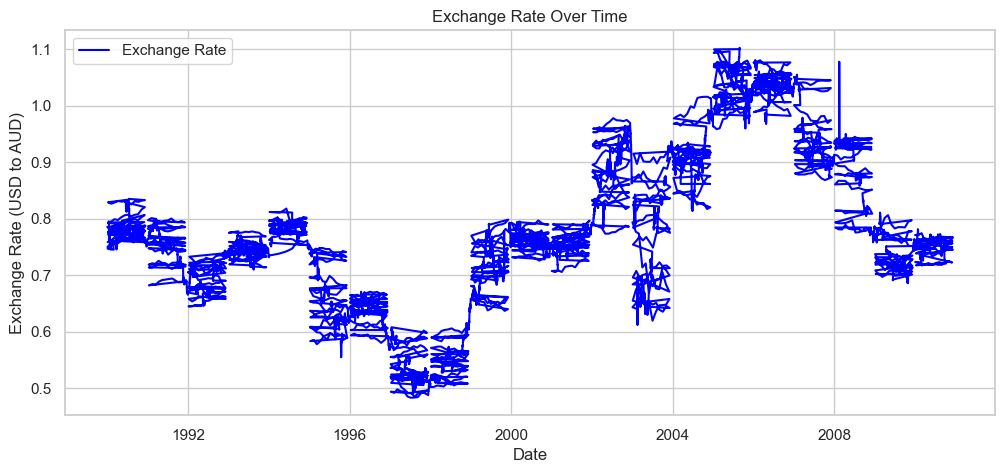

In [34]:
# Plot the time series to check trends and seasonality
plt.figure(figsize=(12,5))
plt.plot(data, label='Exchange Rate', color='blue')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.legend()
plt.show()


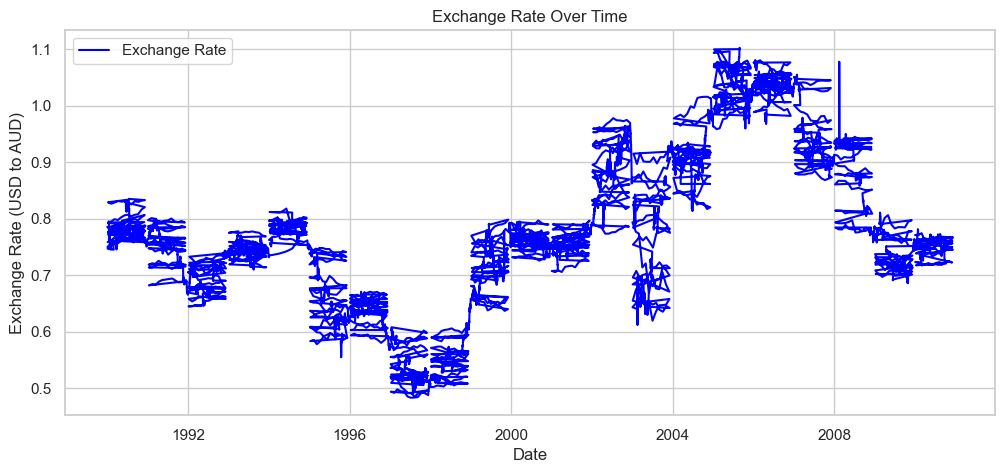

In [36]:
# Plot the time series to check trends and seasonality
plt.figure(figsize=(12,5))
plt.plot(data, label='Exchange Rate', color='blue')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.legend()
plt.show()


In [38]:
# Function to perform Augmented Dickey-Fuller (ADF) test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

# Apply ADF test to check stationarity
adf_test(data.iloc[:, 0])


ADF Statistic: -1.6649941807381343
p-value: 0.44923273535979974
The series is NOT stationary.


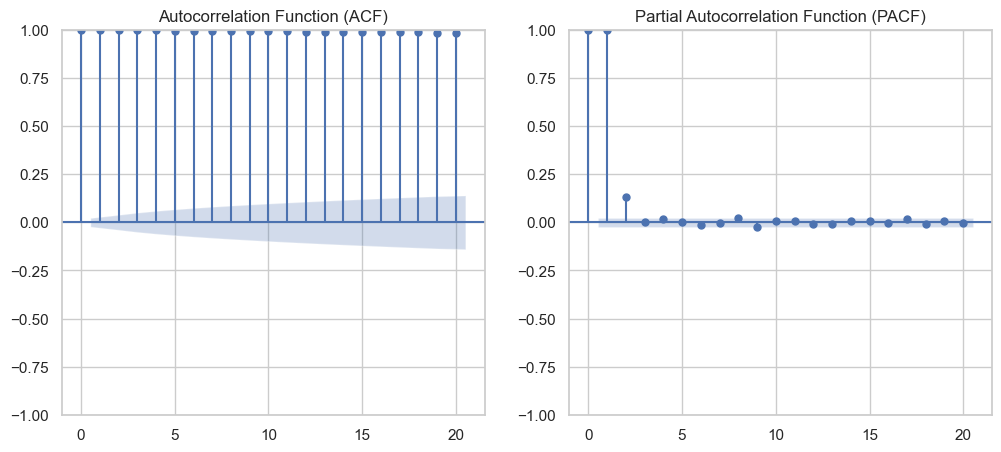

In [40]:
# Plot ACF and PACF to determine p and q values for ARIMA
plt.figure(figsize=(12,5))
plt.subplot(121)
plot_acf(data.iloc[:, 0], lags=20, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

plt.subplot(122)
plot_pacf(data.iloc[:, 0], lags=20, ax=plt.gca())
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()


In [42]:
# Define ARIMA parameters based on ACF/PACF plots
p, d, q = 1, 1, 1  # Adjust based on ACF/PACF analysis

# Fit ARIMA model
arima_model = ARIMA(data, order=(p, d, q))
arima_result = arima_model.fit()

# Print model summary
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 26 Feb 2025   AIC                         -56102.322
Time:                        11:11:28   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

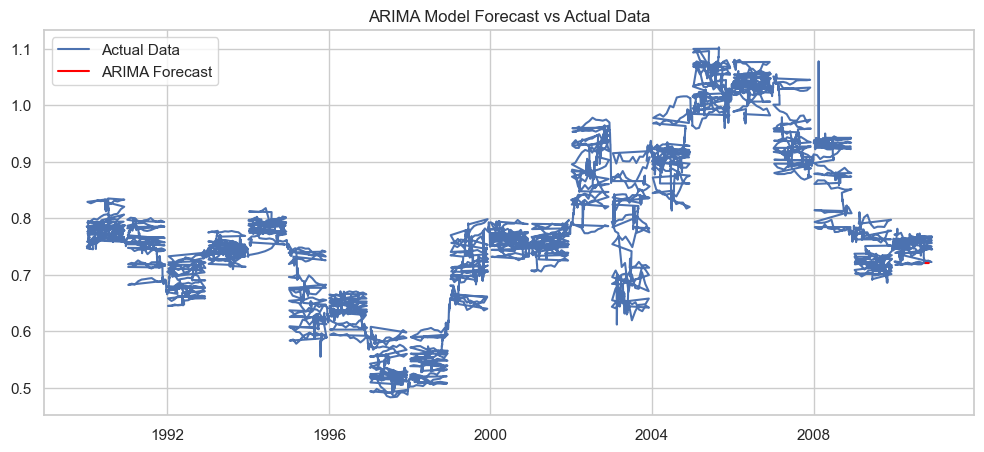

In [44]:
# Forecast next 30 days
forecast_arima = arima_result.forecast(steps=30)

# Plot actual data vs. ARIMA forecast
plt.figure(figsize=(12,5))
plt.plot(data, label='Actual Data')
plt.plot(pd.date_range(start=data.index[-1], periods=30, freq='D'), forecast_arima, label='ARIMA Forecast', color='red')
plt.legend()
plt.title("ARIMA Model Forecast vs Actual Data")
plt.show()


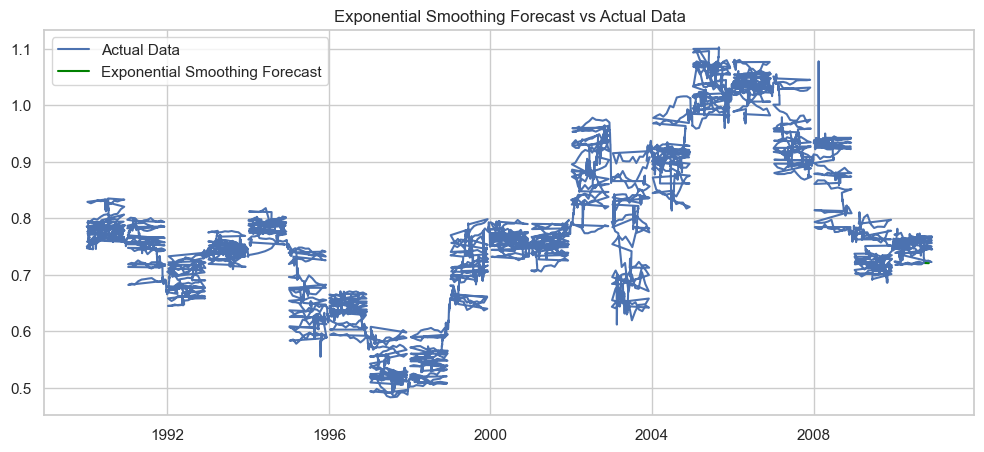

In [46]:
# Fit Holt-Winters Exponential Smoothing Model
exp_model = ExponentialSmoothing(data, trend='add', seasonal=None).fit()

# Forecast next 30 days
forecast_exp = exp_model.forecast(steps=30)

# Plot actual data vs. Exponential Smoothing forecast
plt.figure(figsize=(12,5))
plt.plot(data, label='Actual Data')
plt.plot(pd.date_range(start=data.index[-1], periods=30, freq='D'), forecast_exp, label='Exponential Smoothing Forecast', color='green')
plt.legend()
plt.title("Exponential Smoothing Forecast vs Actual Data")
plt.show()


In [48]:
# Function to compute evaluation metrics
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    return mae, rmse

# Evaluate ARIMA and Exponential Smoothing forecasts
arima_mae, arima_rmse = evaluate_model(data.iloc[-30:], forecast_arima)
exp_mae, exp_rmse = evaluate_model(data.iloc[-30:], forecast_exp)

print(f'ARIMA Model - MAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}')
print(f'Exponential Smoothing Model - MAE: {exp_mae:.4f}, RMSE: {exp_rmse:.4f}')


ARIMA Model - MAE: 0.0127, RMSE: 0.0170
Exponential Smoothing Model - MAE: 0.0128, RMSE: 0.0170


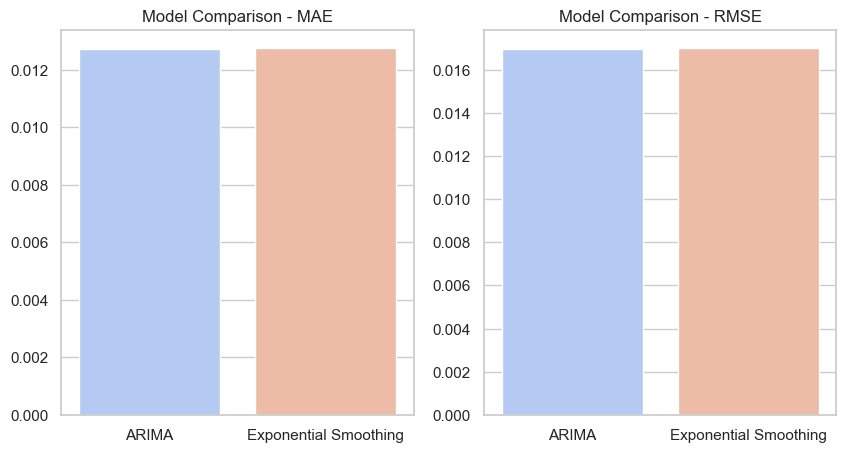

The ARIMA model performed better based on RMSE.


In [50]:
# Compare ARIMA and Exponential Smoothing errors
models = ['ARIMA', 'Exponential Smoothing']
mae_values = [arima_mae, exp_mae]
rmse_values = [arima_rmse, exp_rmse]

# Plot comparison of MAE and RMSE
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.barplot(x=models, y=mae_values, palette='coolwarm')
plt.title("Model Comparison - MAE")

plt.subplot(1,2,2)
sns.barplot(x=models, y=rmse_values, palette='coolwarm')
plt.title("Model Comparison - RMSE")

plt.show()

# Conclusion
if arima_rmse < exp_rmse:
    print("The ARIMA model performed better based on RMSE.")
else:
    print("The Exponential Smoothing model performed better based on RMSE.")
